In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tempfile, sys, os
sys.path.insert(0, os.path.abspath('..'))
from deepexplain.tensorflow import DeepExplain
from explain_helper import explain_model, load_image
from distutils.version import LooseVersion
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from scipy.signal import argrelextrema

/Users/ptien/miniconda/envs/py3-env-1/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/Users/ptien/.matplotlib/matplotlibrc", line #2
  (fname, cnt))
/Users/ptien/miniconda/envs/py3-env-1/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/Users/ptien/.matplotlib/matplotlibrc", line #3
  (fname, cnt))
/Users/ptien/miniconda/envs/py3-env-1/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/Users/ptien/.matplotlib/matplotlibrc", line #4
  (fname, cnt))
/Users/ptien/miniconda/envs/py3-env-1/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/Users/ptien/.matplotlib/matplotlibrc", line #5
  (fname, cnt))
/Users/ptien/miniconda/envs/py3-env-1/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/Users/ptien/.matplotlib/matplotlibrc", line #6
  (fname, cnt))
/Users/ptien/miniconda/envs/py

In [2]:
%matplotlib inline
import pandas as pd
import PIL
import tensorflow as tf
import numpy as np

In [3]:
image_path = "/Users/ptien/tfds-download/apple2orange/testA/"
base_image_path = "/Users/ptien/tfds-download/apple2orange/experiment2-500000/generated_y/"
file_name = ["n07740461_10011.jpg", "n07740461_240.jpg", "n07740461_14960.jpg", 
             "n07740461_2770.jpg", "n07740461_14600.jpg", "n07740461_14531.jpg", 
             "n07740461_14300.jpg", "n07740461_10371.jpg", "n07740461_10571.jpg"]
# file_name = ["n07740461_10371.jpg", "n07740461_10571.jpg"]
model_path = "/Users/ptien/DeepLearning/research/gan/apple2orange.h5"
num_class = 2
labels = [0]*len(file_name) # [0,0,0,0,0,0]
explain_types = ["intgrad", "intgrad_base", "deeplift", "deeplift_base"]
# explain_types = ["intgrad", "intgrad_base"]
stochastic_mask_flag = False
imag, y_label, base_imag = load_image(image_path, base_image_path, file_name, labels, num_class)

In [6]:
def kernel_density(original_image, gan_image, file_name, bandwidth = 0.02, op="min", filter_=True):
    num_fig = original_image.shape[0]
    assert num_fig == len(file_name), "Number of figure is not the same."
    diff_image_base = original_image - gan_image
    X_plot = np.linspace(-1, 1, 1000)[:, np.newaxis]
    bins = np.linspace(-1, 1, 1000)
    local_min_max = {}
    comparison_op = {
        "min": np.less,
        "max": np.greater
    }
    print("compare operator: {x}".format(x=op))
    kernel_arr = []
    for i in range(num_fig):
        X = diff_image_base[i].reshape(-1,1)
        if filter_:
            X = [ xx for xx in X if abs(xx) >= bandwidth]
        # Gaussian KDE
        kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(X)
        log_dens = kde.score_samples(X_plot)
        kernel_arr += [log_dens]
        
        compare_op = comparison_op[op]
        kernel_y = np.exp(log_dens)
        local_indexs = argrelextrema(kernel_y, compare_op)[0]
        local_min_max[file_name[i]] = X_plot[local_indexs]
        del X
    return kernel_arr, local_min_max, X_plot

In [5]:
kernel_arr, local_min_max, X_plot = kernel_density(imag, base_imag, file_name, bandwidth = 0.02, op="min")

compare operator: min


In [6]:
# stochastic_mask_flag = ["<=-0.04704705", "<=-0.1971972"]
stochastic_mask_flag

False

In [7]:
output = explain_model(model_path, imag, y_label, num_class, base_imag, explain_types,
                       steps=200,
                       stochastic_mask_flag=stochastic_mask_flag)

W0429 14:10:43.100915 140736719762368 deprecation.py:506] From /Users/ptien/miniconda/envs/py3-env-1/lib/python3.6/site-packages/tensorflow_core/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0429 14:10:43.102415 140736719762368 deprecation.py:506] From /Users/ptien/miniconda/envs/py3-env-1/lib/python3.6/site-packages/tensorflow_core/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0429 14:10:43.137477 140736719762368 deprecation.py:506] From /Users/ptien/miniconda/envs/py3-env-1/lib/python3.6/site-packages/tensorflow_core/python/ops/re

process intgrad
process intgrad_base
process deeplift


W0429 14:56:18.030304 140736719762368 deprecation.py:323] From /Users/ptien/DeepLearning/DeepExplain/deepexplain/tensorflow/methods.py:442: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


process deeplift_base


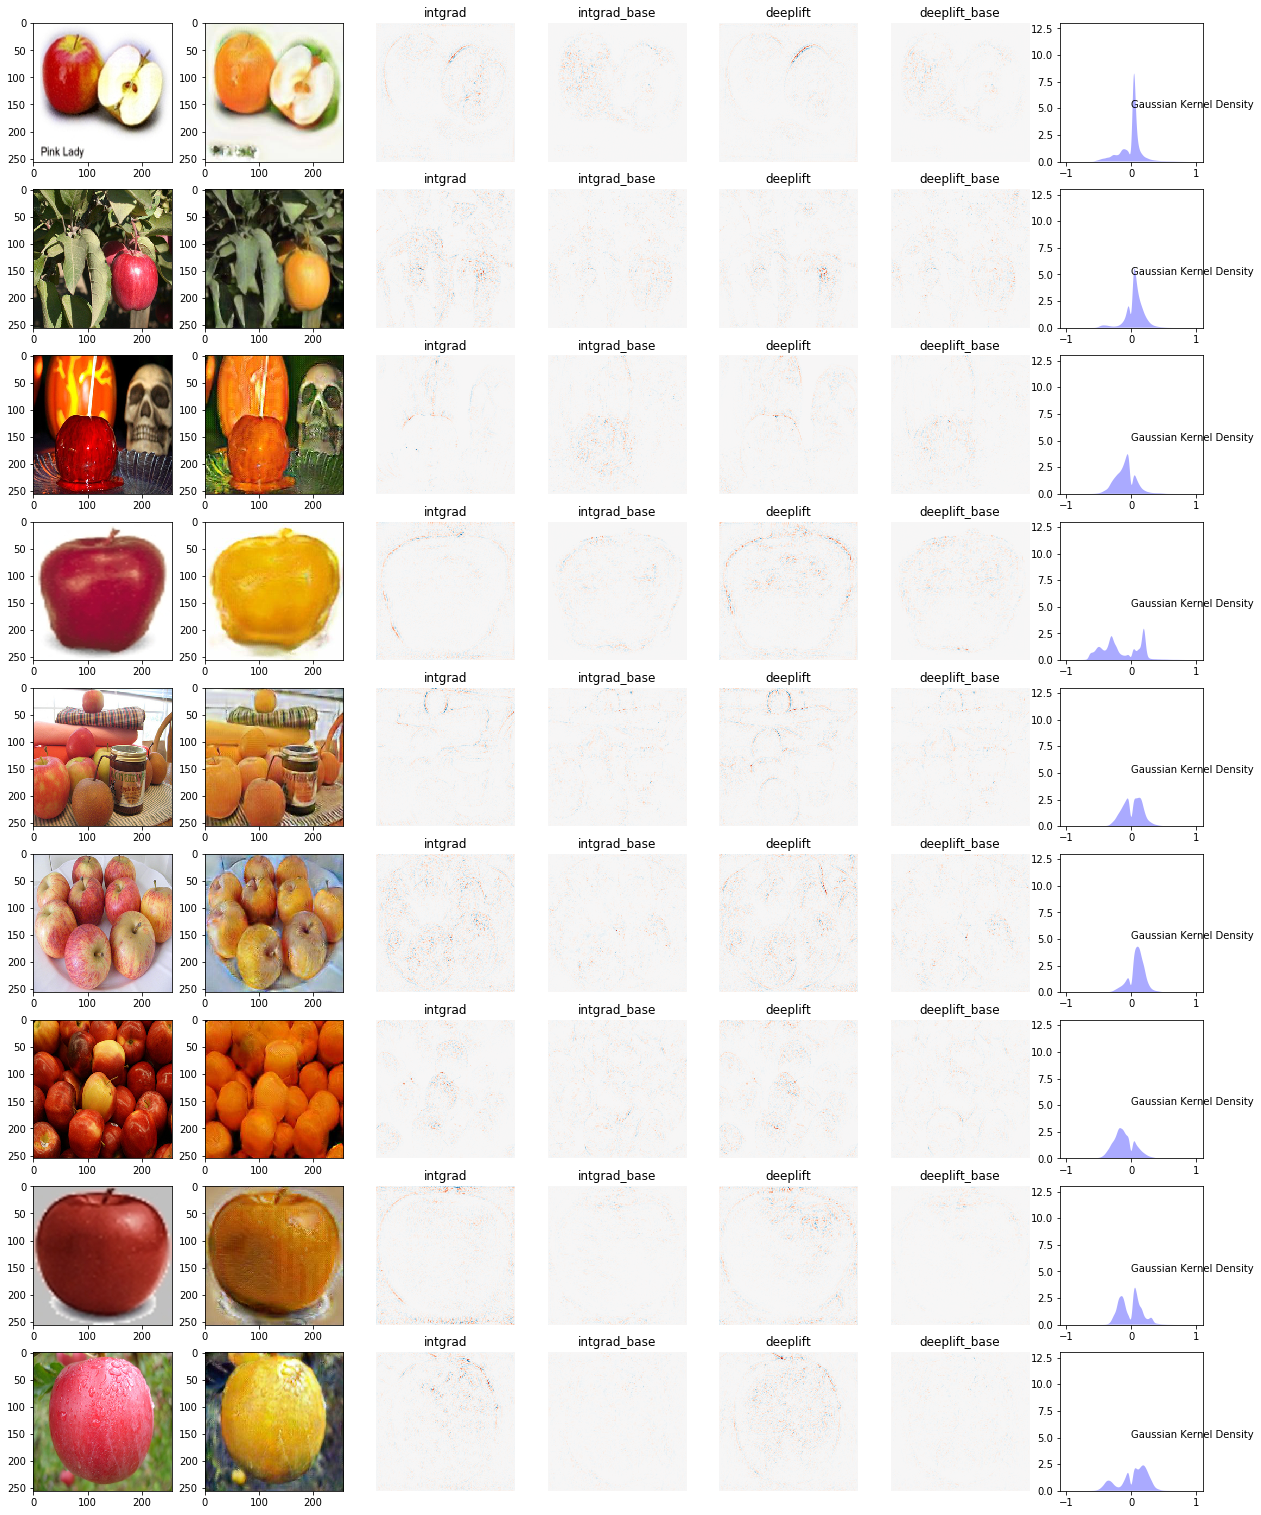

In [8]:
from utils import plot, plt
nrows = len(file_name)
kernel_plot = 1
ncols = 2 + len(explain_types)+kernel_plot # 6
y_min, y_max = 0, 13
xs = imag
attributions_ig = output["intgrad"]
attributions_ig_base_line = output["intgrad_base"]
attributions_dl = output["deeplift"]
attributions_dl_base_line = output["deeplift_base"]
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 3*nrows))
for i in range(nrows):
    a1 = attributions_ig[i]
    a2 = attributions_ig_base_line[i]
    a3 = attributions_dl[i]
    a4 = attributions_dl_base_line[i]
    axes[i, 0].imshow(imag[i])# .title('Original')
    axes[i, 1].imshow(base_imag[i])# .set_title('transformed')
    plot(a1, axis=axes[i,2]).set_title('intgrad')
    plot(a2, axis=axes[i,3]).set_title('intgrad_base')
    plot(a3, axis=axes[i,4]).set_title('deeplift')
    plot(a4, axis=axes[i, 5]).set_title('deeplift_base')
    # kernel_arr += [log_dens]
    log_dens = kernel_arr[i]
    axes[i, 6].fill(X_plot[:, 0], np.exp(log_dens), fc='#AAAAFF')
    axes[i, 6].text(0, 5, "Gaussian Kernel Density")
    axes[i, 6].set_ylim([y_min,y_max])

In [9]:
fig.savefig("apple2orange_explanation_map_1.jpg")

In [10]:
local_min_max["n07740461_10371.jpg"], local_min_max["n07740461_10571.jpg"]

(array([[-0.01301301],
        [ 0.25525526]]), array([[-0.1971972 ],
        [-0.001001  ],
        [ 0.10510511]]))

In [11]:
image_path = "/Users/ptien/tfds-download/apple2orange/testA/"
base_image_path = "/Users/ptien/tfds-download/apple2orange/experiment2-500000/generated_y/"
file_name = ["n07740461_10371.jpg", "n07740461_10571.jpg"]
model_path = "/Users/ptien/DeepLearning/research/gan/apple2orange.h5"
num_class = 2
labels = [0]*len(file_name) # [0,0,0,0,0,0]
explain_types = ["intgrad", "intgrad_base", "deeplift", "deeplift_base"]
# stochastic_mask_flag = ["<=-0.04704705", "<=-0.1971972"]
stochastic_mask_flag = ["<=-0.01301301", "<=-0.1971972"]
imag, y_label, base_imag = load_image(image_path, base_image_path, file_name, labels, num_class)

In [12]:
output = explain_model(model_path, imag, y_label, num_class, base_imag, explain_types,
                       steps=200,
                       stochastic_mask_flag=stochastic_mask_flag)

process intgrad
process intgrad_base
[!!!!!] Use additional mask in IG.
process deeplift
process deeplift_base
[!!!!!] Use additional mask in DeepLIFT


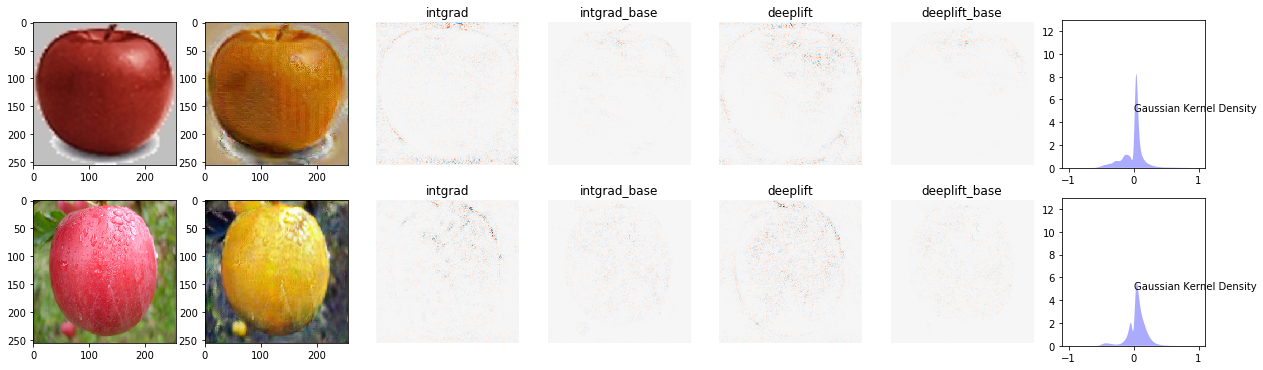

In [13]:
from utils import plot, plt
nrows = len(file_name)
kernel_plot = 1
ncols = 2 + len(explain_types)+kernel_plot # 6
xs = imag
attributions_ig = output["intgrad"]
attributions_ig_base_line = output["intgrad_base"]
attributions_dl = output["deeplift"]
attributions_dl_base_line = output["deeplift_base"]
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 3*nrows))
for i in range(nrows):
    a1 = attributions_ig[i]
    a2 = attributions_ig_base_line[i]
    a3 = attributions_dl[i]
    a4 = attributions_dl_base_line[i]
    axes[i, 0].imshow(imag[i])# .title('Original')
    axes[i, 1].imshow(base_imag[i])# .set_title('transformed')
    plot(a1, axis=axes[i,2]).set_title('intgrad')
    plot(a2, axis=axes[i,3]).set_title('intgrad_base')
    plot(a3, axis=axes[i,4]).set_title('deeplift')
    plot(a4, axis=axes[i, 5]).set_title('deeplift_base')
    # kernel_arr += [log_dens]
    log_dens = kernel_arr[i]
    axes[i, 6].fill(X_plot[:, 0], np.exp(log_dens), fc='#AAAAFF')
    axes[i, 6].text(0, 5, "Gaussian Kernel Density")
    axes[i, 6].set_ylim([y_min,y_max])

In [14]:
fig.savefig("apple2orange_explanation_map_2.jpg")

In [15]:
image_path = "/Users/ptien/tfds-download/horse2zebra/testA/"
base_image_path = "/Users/ptien/tfds-download/horse2zebra/experiment-500000/generated_y/"
file_name = ["n02381460_120.jpg", "n02381460_7500.jpg", "n02381460_4410.jpg", "n02381460_510.jpg"]
# file_name = ["n02381460_120.jpg"]
model_path = "/Users/ptien/tfds-download/models_ckpts/tfgan_logdir/h2z/classification/model_ckpt/modelh5/horse2zebra_keras.h5"
num_class = 2
labels = [0]* len(file_name)
explain_types = ["intgrad", "intgrad_base", "deeplift", "deeplift_base"]
imag, y_label, base_imag = load_image(image_path, base_image_path, file_name, labels, num_class)
# stochastic_mask_flag = ["<=-0.0070"]
stochastic_mask_flag = False

In [17]:
kernel_arr, local_min_max, X_plot = kernel_density(imag, base_imag, file_name, bandwidth = 0.02, op="min")

compare operator: min


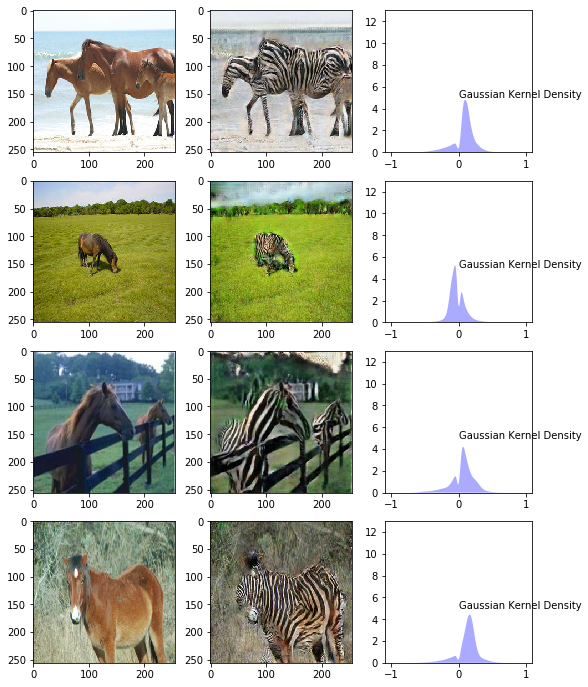

In [18]:
nrows = len(file_name)
fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(3*3, 3*nrows))
axes = axes.reshape(nrows, 3)
for i in range(nrows):
    # a4 = attributions_dl_base_line[i]
    axes[i, 0].imshow(imag[i])# .title('Original')
    axes[i, 1].imshow(base_imag[i])# .set_title('transformed')
    log_dens = kernel_arr[i]
    axes[i, 2].fill(X_plot[:, 0], np.exp(log_dens), fc='#AAAAFF')
    axes[i, 2].text(0, 5, "Gaussian Kernel Density")
    axes[i, 2].set_ylim([y_min,y_max])

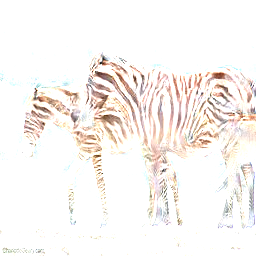

In [11]:
diff_imag = imag - base_imag
tf.keras.preprocessing.image.array_to_img(diff_imag[0]* (diff_imag[0] < -0.0070))

In [71]:
from scipy.signal import argrelextrema
for i in range(num_fig):
    x1 = np.exp(kernel_arr[i])
    # for local maxima
    # argrelextrema(x1, np.greater)

    # for local minima
    local_indexs = argrelextrema(x1, np.less)[0]
    print(i, X_plot[local_indexs])

0 [[-0.00700701]
 [ 0.7977978 ]
 [ 0.86986987]]


In [19]:
output = explain_model(model_path, imag, y_label, num_class, base_imag, explain_types,
                       steps=200,
                       stochastic_mask_flag=stochastic_mask_flag)

process intgrad
process intgrad_base
process deeplift
process deeplift_base


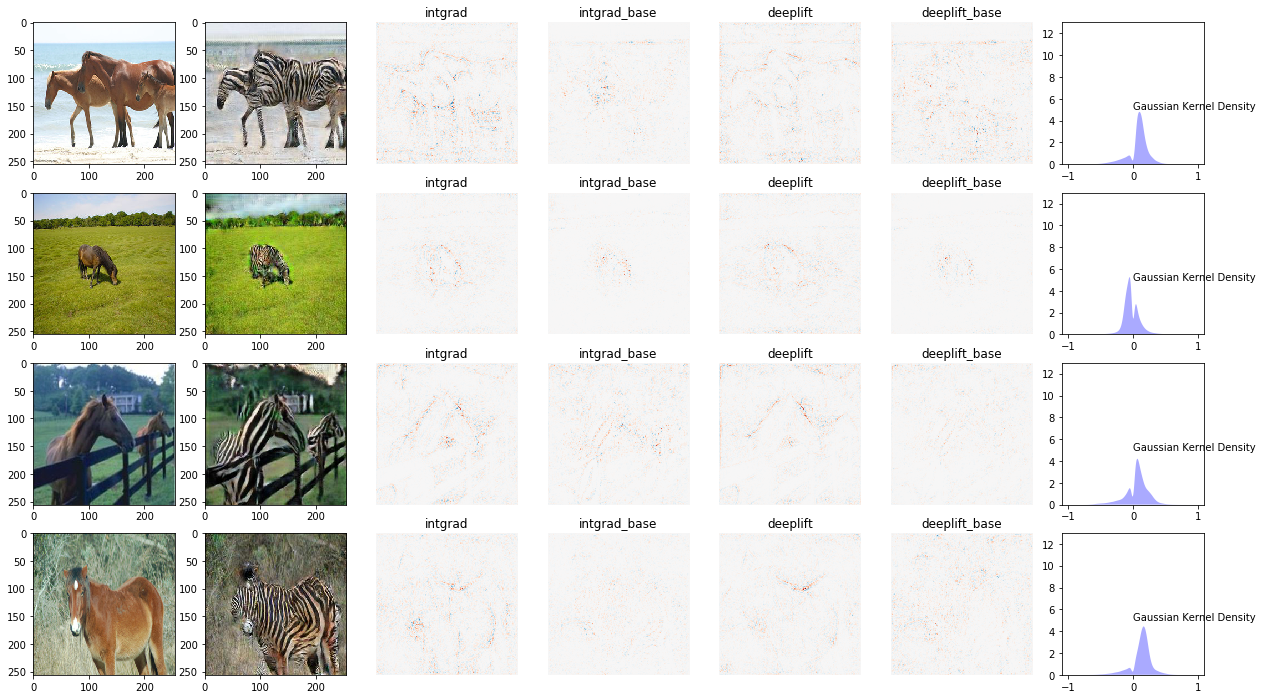

In [20]:
from utils import plot, plt
nrows = len(file_name)
kernel_plot = 1
ncols = 2 + len(explain_types)+kernel_plot # 6
xs = imag
attributions_ig = output["intgrad"]
attributions_ig_base_line = output["intgrad_base"]
attributions_dl = output["deeplift"]
attributions_dl_base_line = output["deeplift_base"]
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 3*nrows))
axes = axes.reshape(nrows, ncols)
for i in range(nrows):
    a1 = attributions_ig[i]
    a2 = attributions_ig_base_line[i]
    a3 = attributions_dl[i]
    a4 = attributions_dl_base_line[i]
    axes[i, 0].imshow(imag[i])# .title('Original')
    axes[i, 1].imshow(base_imag[i])# .set_title('transformed')
    plot(a1, axis=axes[i,2]).set_title('intgrad')
    plot(a2, axis=axes[i,3]).set_title('intgrad_base')
    plot(a3, axis=axes[i,4]).set_title('deeplift')
    plot(a4, axis=axes[i, 5]).set_title('deeplift_base')
    # kernel_arr += [log_dens]
    log_dens = kernel_arr[i]
    axes[i, 6].fill(X_plot[:, 0], np.exp(log_dens), fc='#AAAAFF')
    axes[i, 6].text(0, 5, "Gaussian Kernel Density")
    axes[i, 6].set_ylim([y_min,y_max])

In [ ]:
# model_path = "/Users/ptien/tfds-download/models_ckpts/tfgan_logdir/h2z/classification/model_ckpt/model-001-0.642115.h5"

In [18]:
fig.savefig("hourse2zebra_explanation_map_1.jpg")

In [26]:
image_path = "/Users/ptien/tfds-download/horse2zebra/testA/"
base_image_path = "/Users/ptien/tfds-download/horse2zebra/experiment-500000/generated_y/"
# file_name = ["n02381460_120.jpg"]
file_name = ["n02381460_120.jpg", "n02381460_4410.jpg", "n02381460_510.jpg"]
model_path = "/Users/ptien/tfds-download/models_ckpts/tfgan_logdir/h2z/classification/model_ckpt/modelh5/horse2zebra_keras.h5"
num_class = 2
labels = [0]* len(file_name)
explain_types = ["intgrad", "intgrad_base", "deeplift", "deeplift_base"]
# explain_types = ["deeplift_base"]
imag, y_label, base_imag = load_image(image_path, base_image_path, file_name, labels, num_class)
stochastic_mask_flag = ["<=-0.00700701", "<=-0.00700701", "<=-0.00500501"]

In [27]:
local_min_max["n02381460_120.jpg"], local_min_max["n02381460_4410.jpg"], local_min_max["n02381460_510.jpg"]

(array([[-0.00700701],
        [ 0.7977978 ],
        [ 0.86986987]]), array([[-0.00700701],
        [ 0.75175175]]), array([[-0.00500501],
        [ 0.82782783],
        [ 0.92792793]]))

In [28]:
stochastic_mask_flag

['<=-0.00700701', '<=-0.00700701', '<=-0.00500501']

In [29]:
output = explain_model(model_path, imag, y_label, num_class, base_imag, explain_types,
                       steps=200,
                       stochastic_mask_flag=stochastic_mask_flag)

process intgrad
process intgrad_base
[!!!!!] Use additional mask in IG.
process deeplift
process deeplift_base
[!!!!!] Use additional mask in DeepLIFT


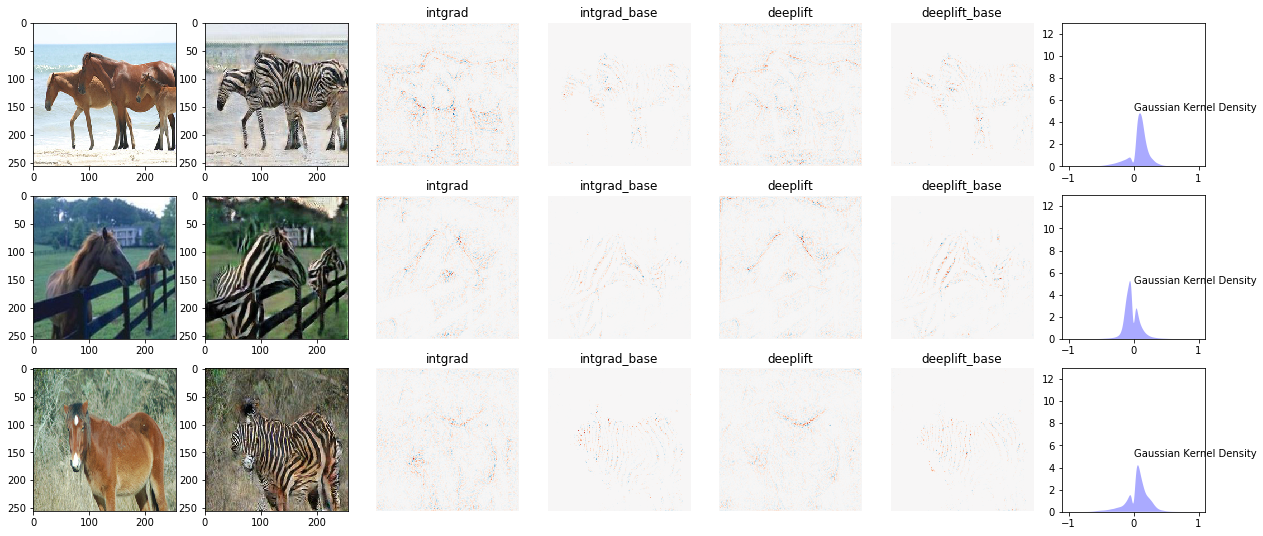

In [30]:
from utils import plot, plt
nrows = len(file_name)
kernel_plot = 1
ncols = 2 + len(explain_types)+kernel_plot # 6
xs = imag
attributions_ig = output["intgrad"]
attributions_ig_base_line = output["intgrad_base"]
attributions_dl = output["deeplift"]
attributions_dl_base_line = output["deeplift_base"]
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 3*nrows))
for i in range(nrows):
    a1 = attributions_ig[i]
    a2 = attributions_ig_base_line[i]
    a3 = attributions_dl[i]
    a4 = attributions_dl_base_line[i]
    axes[i, 0].imshow(imag[i])# .title('Original')
    axes[i, 1].imshow(base_imag[i])# .set_title('transformed')
    plot(a1, axis=axes[i,2]).set_title('intgrad')
    plot(a2, axis=axes[i,3]).set_title('intgrad_base')
    plot(a3, axis=axes[i,4]).set_title('deeplift')
    plot(a4, axis=axes[i, 5]).set_title('deeplift_base')
    # kernel_arr += [log_dens]
    log_dens = kernel_arr[i]
    axes[i, 6].fill(X_plot[:, 0], np.exp(log_dens), fc='#AAAAFF')
    axes[i, 6].text(0, 5, "Gaussian Kernel Density")
    axes[i, 6].set_ylim([y_min,y_max])

In [15]:
fig.savefig("hourse2zebra_explanation_map_2.jpg")

### GAN performance

In [33]:
image_path = "/Users/ptien/tfds-download/apple2orange/testA/"
gan_image_path_1 = "/Users/ptien/tfds-download/apple2orange/experiment2-500000/generated_y/generated_from_"
gan_image_path_2 = "/Users/ptien/tfds-download/apple2orange/experiment-1000/generated_y/generated_from_"
gan_image_path_3 = "/Users/ptien/tfds-download/apple2orange/experiment-0/generated_y/generated_from_"

image_paths = [image_path, gan_image_path_1, gan_image_path_2, gan_image_path_3]
file_name = ["n07740461_240.jpg", "n07740461_411.jpg", "n07740461_14960.jpg", 
             "n07740461_40.jpg", "n07740461_1690.jpg", "n07740461_12921.jpg"]

def load_batch_images(image_paths, file_name):
    res = []
    for p in image_paths:
        res_p = []
        for f in file_name:
            path_ = p + f
            imag_temp = tf.keras.preprocessing.image.load_img(path_, target_size=(256, 256, 3))
            input_np= tf.keras.preprocessing.image.img_to_array(imag_temp)/255.
            res_p += [input_np]
        res += [res_p]
    res = np.array(res)
    return res
# imag, y_label, base_imag = load_image(image_path, base_image_path, file_name, labels, num_class)
images_collection = load_batch_images(image_paths, file_name)

In [34]:
# images_collection
images_collection[0].shape

(6, 256, 256, 3)

In [35]:
original_imag = images_collection[0]
gan_imag = images_collection[1]
kernel_arr, local_min_max, X_plot = kernel_density(original_imag, gan_imag, file_name, 
                                                   bandwidth = 0.02, op="min", filter_=False)


compare operator: min


In [36]:
original_imag = images_collection[0]
gan_imag2 = images_collection[2]
kernel_arr2, local_min_max2, X_plot2 = kernel_density(original_imag, gan_imag2, file_name, 
                                                   bandwidth = 0.02, op="min", filter_=False)

compare operator: min


In [37]:
original_imag = images_collection[0]
gan_imag3 = images_collection[3]
kernel_arr3, local_min_max3, X_plot3 = kernel_density(original_imag, gan_imag3, file_name, 
                                                   bandwidth = 0.02, op="min", filter_=False)

compare operator: min


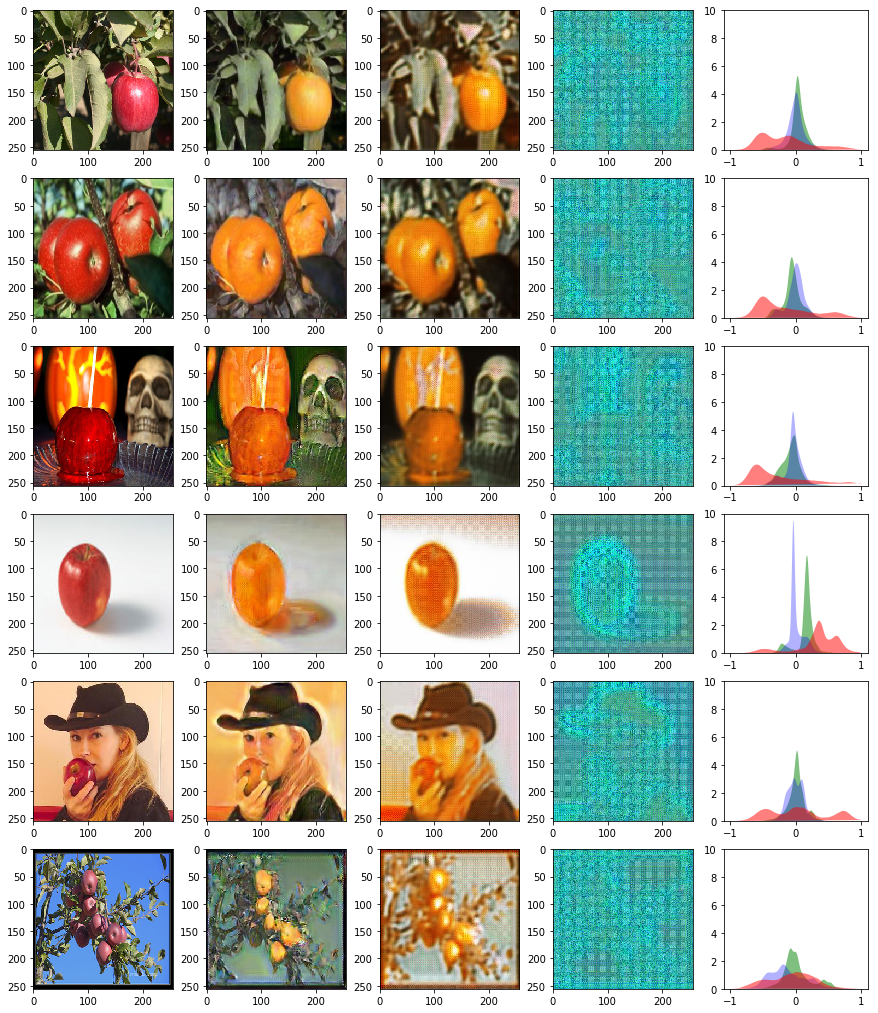

In [38]:
from utils import plot, plt
nrows = len(file_name)
ncols = 5
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 3*nrows))
axes = axes.reshape(nrows, ncols)
y_min,y_max = 0, 10
for i in range(nrows):
    # a4 = attributions_dl_base_line[i]
    axes[i, 0].imshow(original_imag[i])# .set_title('Original')
    axes[i, 1].imshow(gan_imag[i])# .set_title('gan-1')
    axes[i, 2].imshow(gan_imag2[i])# .set_title('gan-2')
    axes[i, 3].imshow(gan_imag3[i])# .set_title('gan-3')
    log_dens = kernel_arr[i]
    log_dens2 = kernel_arr2[i]
    log_dens3 = kernel_arr3[i]
    axes[i, 4].fill(X_plot[:, 0], np.exp(log_dens), fc='green', alpha=0.5, label="gan-1")
    axes[i, 4].fill(X_plot2[:, 0], np.exp(log_dens2), fc='blue', alpha=0.3, label="gan-2")
    axes[i, 4].fill(X_plot3[:, 0], np.exp(log_dens3), fc='red', alpha=0.5, label="gan-3")
    # axes[i, 0].text(0, 5, str(i))
    axes[i, 4].set_ylim([y_min,y_max])

In [39]:
fig.savefig("gan_performance_1.jpg")

In [5]:
# count how many pixels corresponding to singal. (num_signal_pixel)
# diff_imag = (image - transformed image from GAN)/2
# sum_imag = (image + transformed image from GAN)/2
# assume imag can be represented in the 256*256*3 dimension vector space.
# num_signal_pixel = (np.multiply(dff_image, sum_image) > 0.0).sum()

# assume GAN succeed transforming the target features.
# we want to extract the part of pixel corresponding to background and use that as a baseline input in DeepExplain.
# how:
# sol 1:
# the diff_imag (image - transformed image from GAN) can be sorted ascedningly.
# the real background corresponds to very small diff.
# thus, we use top-num_signal_pixel largest element as a threshold to distinguish real background and singal.
# use this threshold to construct the baseline.
# a) if x < threshold, leave it as the same.
# b) else, make it zero.
# thus, when we use this image as baseline in the IG, the real background will be canceled out. 
# And the baseline of the feature will be zero.

In [3]:
from copy import deepcopy

def build_base_line_v0(imag_input, gan_imag_input):
    """ not finished yet!!!"""
    assert imag_input.shape == gan_imag_input.shape
    assert len(imag_input.shape) == 4, "Expect 4-dim, (num_imag, H, W, C)"
    num_imags = imag_input.shape[0]
    
    for i in range(num_imags):
        imag = imag_input[i]
        gan_imag = gan_imag_input[i]
        dff_image = (imag - gan_imag)/2
        sum_image = (imag + gan_imag)/2
        num_signal_pixel = (np.multiply(dff_image, sum_image) > 0.0).sum()

        # consider square. it make sure the smaller become smaller.
        # use mask to obtain real baseline.
        square_diff_image = abs(dff_image)**2
        a1 = square_diff_image.reshape(-1)
        a1 = np.array(sorted(a1))
        num = len(a1)
        a1_shift = a1[:num-1]
        arr_diff = np.array(a1[1:]) - np.array(a1_shift)
        threshold_indexs = arr_diff.argsort()[-num_signal_pixel:][::-1]
        threshold_index = threshold_indexs[-1]
        print("threshold indexs: {x} and pick the last one {y}.".format(x=threshold_indexs,y=threshold_index))
        threshold = a1[threshold_index]
        # if mask=true, it is real background.
        mask = square_diff_image < threshold

        # populate singal by zero and leave real background unchange.
        # it can be used in the deepexplain model, such as IG.
        real_baseline = deepcopy(imag)
        real_baseline[~mask] = 0
    return real_baseline, mask


def build_base_line(imag_input, gan_imag_input, threshold=0.9):
    assert imag_input.shape == gan_imag_input.shape
    assert len(imag_input.shape) == 4, "Expect 4-dim, (num_imag, H, W, C)"
    num_imags = imag_input.shape[0]
    new_baseline = deepcopy(imag_input)
    new_image = deepcopy(imag_input)
    quantile_arr = []
    for i in range(num_imags):
        imag = imag_input[i]
        gan_imag = gan_imag_input[i]
        dff_image = (imag - gan_imag)/2
        sum_image = (imag + gan_imag)/2
        singal_image = np.multiply(dff_image, sum_image)
        singal_image_one_dim_array = sorted(abs(singal_image.reshape(-1)))
        quantile_dict = {}
        for k in range(10):
            k = k/10.
            quantile_dict[k] = np.quantile(singal_image_one_dim_array, k)
        thres = quantile_dict[threshold]
        quantile_arr += [quantile_dict]
        # mask = true, it is new background and we leave new background unchanged.
        mask = abs(singal_image) <= thres
        new_baseline[i][~mask] = 0
        new_image[i][~mask] = 1
    return new_baseline, quantile_arr, new_image